<a href="https://colab.research.google.com/github/N-nolwenn/Remote_Sensing_Image_Analysis/blob/main/OEM_mini_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenEarhMap Semantinc Segmentation

original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo.ipynb

---

### Requirements

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!git clone https://github.com/bao18/open_earth_map.git '/content/drive/My Drive/Colab/OEM/' # <= change path where you save code

In [4]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 42.7 MB/s eta 0:00:00


In [ ]:
#import gdown
#import zipfile

#url = "https://drive.google.com/uc?export=download&confirm=pbef&id=1SqLqv1RCJdiUFnnfIce78M9nJF_KF11U"
#output = "/content/drive/My Drive/Colab/OEM/OpenEathMap_Mini.zip" # <= change path where you save data
#gdown.download(url, output, quiet=False)

In [ ]:
#!unzip -q "/content/drive/MyDrive/Colab/OEM/OpenEarthMap_Mini.zip" -d "/content/drive/My Drive/Colab/OEM/" # <= change path where you save data

### Import
---

In [5]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.1 MB/s eta 0:00:00


In [6]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.1 MB/s eta 0:00:00


In [7]:
import os
import time
import warnings
import numpy as np
import torch
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/drive/My Drive/Colab/OEM') # <= change path where you save code
import open_earth_map as oem

warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Define main parameters

In [8]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "/content/drive/My Drive/Colab/OEM/OpenEarthMap_Mini/"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 0.0001
BATCH_SIZE = 4
NUM_EPOCHS = 25
DEVICE = "cuda"
OUTPUT_DIR = "/content/drive/My Drive/Colab/OEM/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [9]:
print(TRAIN_LIST)
print(VAL_LIST)

/content/drive/My Drive/Colab/OEM/OpenEarthMap_Mini/train.txt
/content/drive/My Drive/Colab/OEM/OpenEarthMap_Mini/val.txt


### Prepare training and validation file lists.

In [10]:
img_paths = [f for f in Path(OEM_DATA_DIR).rglob("images/*.tif")]
#print(img_paths)
train_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in img_paths if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(img_paths))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 1068
Training samples   : 663
Validation samples : 92


### Prepare training and validation augmentations.

In [11]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Define training and validation dataloaders

In [12]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

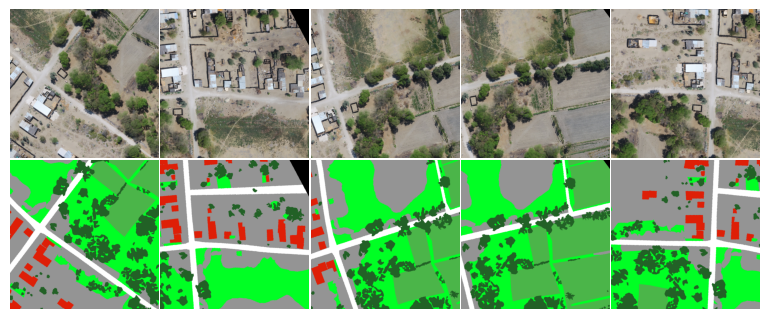

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [14]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

### Define the network architecture, optimizer, and criterion

In [15]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = oem.losses.JaccardLoss()

### Train and validate the network

In [16]:
start = time.time()

max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )
    epoch_score = valid_logs["Score"]
    if max_score < epoch_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Valid: 100%|██████████| 23/23 [00:24<00:00,  1.08s/it, Loss=6.82, Score=0.0864]


model saved

Epoch: 2


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s, Loss=6.39, Score=0.126]


model saved

Epoch: 3


Valid: 100%|██████████| 23/23 [00:18<00:00,  1.22it/s, Loss=6.28, Score=0.135]


model saved

Epoch: 4


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s, Loss=6.23, Score=0.139]


model saved

Epoch: 5


Valid: 100%|██████████| 23/23 [00:18<00:00,  1.25it/s, Loss=6.2, Score=0.141]


model saved

Epoch: 6


Valid: 100%|██████████| 23/23 [00:20<00:00,  1.11it/s, Loss=6.2, Score=0.143]


model saved

Epoch: 7


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s, Loss=6.15, Score=0.149]


model saved

Epoch: 8


Valid: 100%|██████████| 23/23 [00:18<00:00,  1.27it/s, Loss=6.06, Score=0.155]


model saved

Epoch: 9


Valid: 100%|██████████| 23/23 [00:15<00:00,  1.44it/s, Loss=6.07, Score=0.152]



Epoch: 10


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s, Loss=6.07, Score=0.155]


model saved

Epoch: 11


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.33it/s, Loss=6.0, Score=0.163]


model saved

Epoch: 12


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.33it/s, Loss=6.03, Score=0.157]



Epoch: 13


Valid: 100%|██████████| 23/23 [00:15<00:00,  1.44it/s, Loss=5.96, Score=0.165]


model saved

Epoch: 14


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s, Loss=6.06, Score=0.157]



Epoch: 15


Valid: 100%|██████████| 23/23 [00:15<00:00,  1.49it/s, Loss=6.08, Score=0.155]



Epoch: 16


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s, Loss=5.91, Score=0.17]


model saved

Epoch: 17


Valid: 100%|██████████| 23/23 [00:16<00:00,  1.37it/s, Loss=5.78, Score=0.182]


model saved

Epoch: 18


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s, Loss=5.73, Score=0.189]


model saved

Epoch: 19


Valid: 100%|██████████| 23/23 [00:15<00:00,  1.45it/s, Loss=6.03, Score=0.159]



Epoch: 20


Valid: 100%|██████████| 23/23 [00:16<00:00,  1.36it/s, Loss=5.94, Score=0.168]



Epoch: 21


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s, Loss=5.76, Score=0.183]



Epoch: 22


Valid: 100%|██████████| 23/23 [00:16<00:00,  1.41it/s, Loss=5.7, Score=0.19]


model saved

Epoch: 23


Valid: 100%|██████████| 23/23 [00:17<00:00,  1.35it/s, Loss=5.61, Score=0.2]


model saved

Epoch: 24


Valid: 100%|██████████| 23/23 [00:16<00:00,  1.40it/s, Loss=5.72, Score=0.189]



Epoch: 25


Valid: 100%|██████████| 23/23 [00:16<00:00,  1.44it/s, Loss=5.72, Score=0.189]

Elapsed time: 85.569 min


# Testing

### Prepare testing files

In [17]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

Total samples   : 1068
Testing samples : 313


### Define test dataloader

In [18]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None, testing=True)

### Load trained network

In [19]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir=OUTPUT_DIR)

Loaded model:model.pth (Epoch=22, Score=0.200)


### Visualize predictions

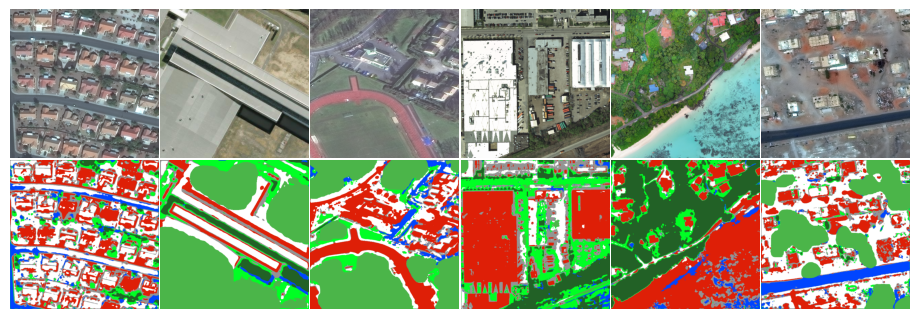

In [20]:
# visualize predictions
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    img = np.moveaxis(img.numpy(), 0, -1)
    prd = oem.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

### Save predictions in png files

In [21]:
import math
from PIL import Image

PR_DIR = "/content/drive/My Drive/Colab/OEM/png" # <= change path where you save predictions
os.makedirs(PR_DIR, exist_ok=True)

save_fns = []

network.eval().to(DEVICE)
for test_fn in test_fns:
    img = Image.fromarray(oem.dataset.load_multiband(test_fn))

    w, h = img.size[:2]
    power_h = math.ceil(np.log2(h) / np.log2(2))
    power_w = math.ceil(np.log2(w) / np.log2(2))
    if 2**power_h != h or 2**power_w != w:
      img = img.resize((2**power_w, 2**power_h), resample=Image.BICUBIC)
    img = np.array(img)

    # test time augmentation
    imgs = []
    imgs.append(img.copy())
    imgs.append(img[:, ::-1, :].copy())
    imgs.append(img[::-1, :, :].copy())
    imgs.append(img[::-1, ::-1, :].copy())

    input = torch.cat([torchvision.transforms.functional.to_tensor(x).unsqueeze(0) for x in imgs], dim=0).float().to(DEVICE)

    pred = []
    with torch.no_grad():
      msk = network(input)
      msk = torch.softmax(msk[:, :, ...], dim=1)
      msk = msk.cpu().numpy()
      pred = (msk[0, :, :, :] + msk[1, :, :, ::-1] + msk[2, :, ::-1, :] + msk[3, :, ::-1, ::-1])/4

    pred = Image.fromarray(pred.argmax(axis=0).astype("uint8"))
    y_pr = pred.resize((w, h), resample=Image.NEAREST)

    filename = os.path.basename(test_fn).replace('tif','png')
    save_fn = os.path.join(PR_DIR, filename)
    y_pr.save(save_fn)
    save_fns.append(save_fn)